In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
%cd /content/drive/MyDrive/Colab Notebooks/segment_anything
!pip install -e.
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load Classification Model (ResNet-18)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load("/content/drive/MyDrive/tumor-1/best_resnet_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Class Labels
class_names = ["Glioma Tumor", "Meningioma Tumor", "No Tumor", "Pituitary Tumor"]

# ---- Step 1: Classification ----
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()

    predicted_label = class_names[predicted_class]
    print(f"🔍 Predicted Class: {predicted_label}")
    return predicted_label, image

# ---- Step 2: Detection & Segmentation ----
def detect_and_segment(image_pil, image_path):
    print("🔎 Running YOLO Detection...")
    image_pil.save("/tmp/uploaded_image.jpg")  # Save PIL image temporarily
    input_img = cv2.imread("/tmp/uploaded_image.jpg")
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    # YOLOv8 ONNX model
    yolo_model = YOLO("/content/drive/MyDrive/brain-tumor/runs/detect/train/weights/best.onnx")
    results = yolo_model.predict(source=input_img, conf=0.25)

    if not results or results[0].boxes.xyxy.numel() == 0:
        print("❌ No tumor detected by YOLO.")
        return

    print("✅ Tumor detected by YOLO.")
    bbox = results[0].boxes.xyxy.tolist()[0]
    x1, y1, x2, y2 = map(int, bbox)

    # ---- SAM ----
    print("🧠 Running SAM segmentation...")
    sam_checkpoint = "/content/drive/MyDrive/Colab Notebooks/sam_vit_h.pth"
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to("cpu")
    predictor = SamPredictor(sam)
    predictor.set_image(input_img)

    masks, _, _ = predictor.predict(box=np.array(bbox)[None, :], multimask_output=False)
    mask = masks[0]

    # Visualization
    detected_image = input_img.copy()
    segmented_image = input_img.copy()
    cv2.rectangle(detected_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    segmented_image[mask > 0] = [255, 0, 0]

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_img)
    axes[0].set_title("Input Image")
    axes[1].imshow(detected_image)
    axes[1].set_title("Detected Tumor (YOLO)")
    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title("Tumor Mask (SAM)")
    axes[3].imshow(segmented_image)
    axes[3].set_title("Segmented Tumor (Overlay)")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    print("✅ Segmentation completed.")

# ---- Final Execution ----
image_path = "/content/drive/MyDrive/glioma_5.jpg"
predicted_label, image_pil = classify_image(image_path)

if predicted_label != "No Tumor":
    detect_and_segment(image_pil, image_path)
else:
    print("🧠 No tumor detected. Detection & segmentation skipped.")


The model pipeline starts with ResNet-18, a convolutional neural network used for classifying medical images into one of four categories: "Glioma Tumor," "Meningioma Tumor," "No Tumor," or "Pituitary Tumor." If the image is classified as containing a tumor, the pipeline proceeds to the next step; otherwise, the process stops.



In [ ]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models

# Input image path
image_path = "/content/drive/MyDrive/tumor_samples/menig/m3-78-_jpg.rf.c41a1a68b8d6f7c84ea00e2d08ad56c8.jpg"
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load ResNet-18 classification model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load("/content/drive/MyDrive/tumor-1/best_resnet_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Class labels
class_names = ["Glioma Tumor", "Meningioma Tumor", "No Tumor", "Pituitary Tumor"]

# Classification
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
    label = class_names[predicted_class]
    print(f" Predicted Class: {label}")
    return label, image

# Run classification
predicted_label, image_pil = classify_image(image_path)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 Predicted Class: Meningioma Tumor


Next, YOLO (You Only Look Once) is employed for object detection. It locates the tumor within the image by predicting bounding boxes around detected objects. YOLO outputs the coordinates of these boxes, which are used to isolate the region of interest for the next step.


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np

# YOLO detection only if tumor exists
run_sam = False
if predicted_label != "No Tumor":
    print("🔎 Running YOLO Detection...")
    image_pil.save("/tmp/uploaded_image.jpg")
    input_img = cv2.imread("/tmp/uploaded_image.jpg")
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    # Load YOLO model
    yolo_model = YOLO("/content/drive/MyDrive/brain-tumor/runs/detect/train/weights/best.pt")
    results = yolo_model.predict(source=input_img, conf=0.25)

    if not results or results[0].boxes.xyxy.numel() == 0:
        print("SOORY FOR THIS MODEL CANNOT ABLE DETECT THE TUMOR.")
    else:
        print("Tumor detected by YOLO.")
        bbox = results[0].boxes.xyxy.tolist()[0]
        run_sam = True
else:
    print(" No tumor detected. Detection & segmentation skipped.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔎 Running YOLO Detection...

0: 640x640 1 Meningioma, 38.5ms
Speed: 7.4ms preprocess, 38.5ms inference, 414.4ms postprocess per image at shape (1, 3, 640, 640)
Tumor detected by YOLO.


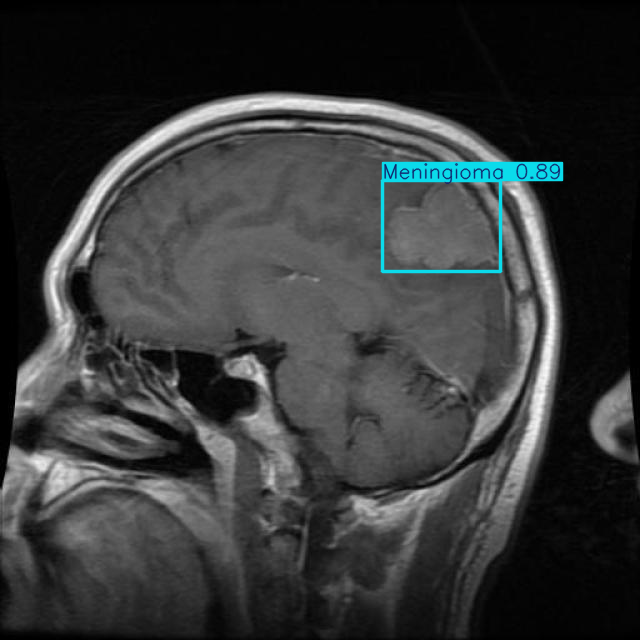

In [ ]:
results[0].show()

In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Glioma', 1: 'Meningioma', 2: 'Pituitary tumor'}
 obb: None
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
    


Finally, SAM (Segment Anything Model) is used for segmentation. Using the bounding box coordinates from YOLO, SAM applies a vision transformer to generate a pixel-level mask, accurately segmenting the tumor from the rest of the image. This process ensures precise tumor localization and delineation, making the entire pipeline effective for medical image analysis.

Running SAM segmentation...


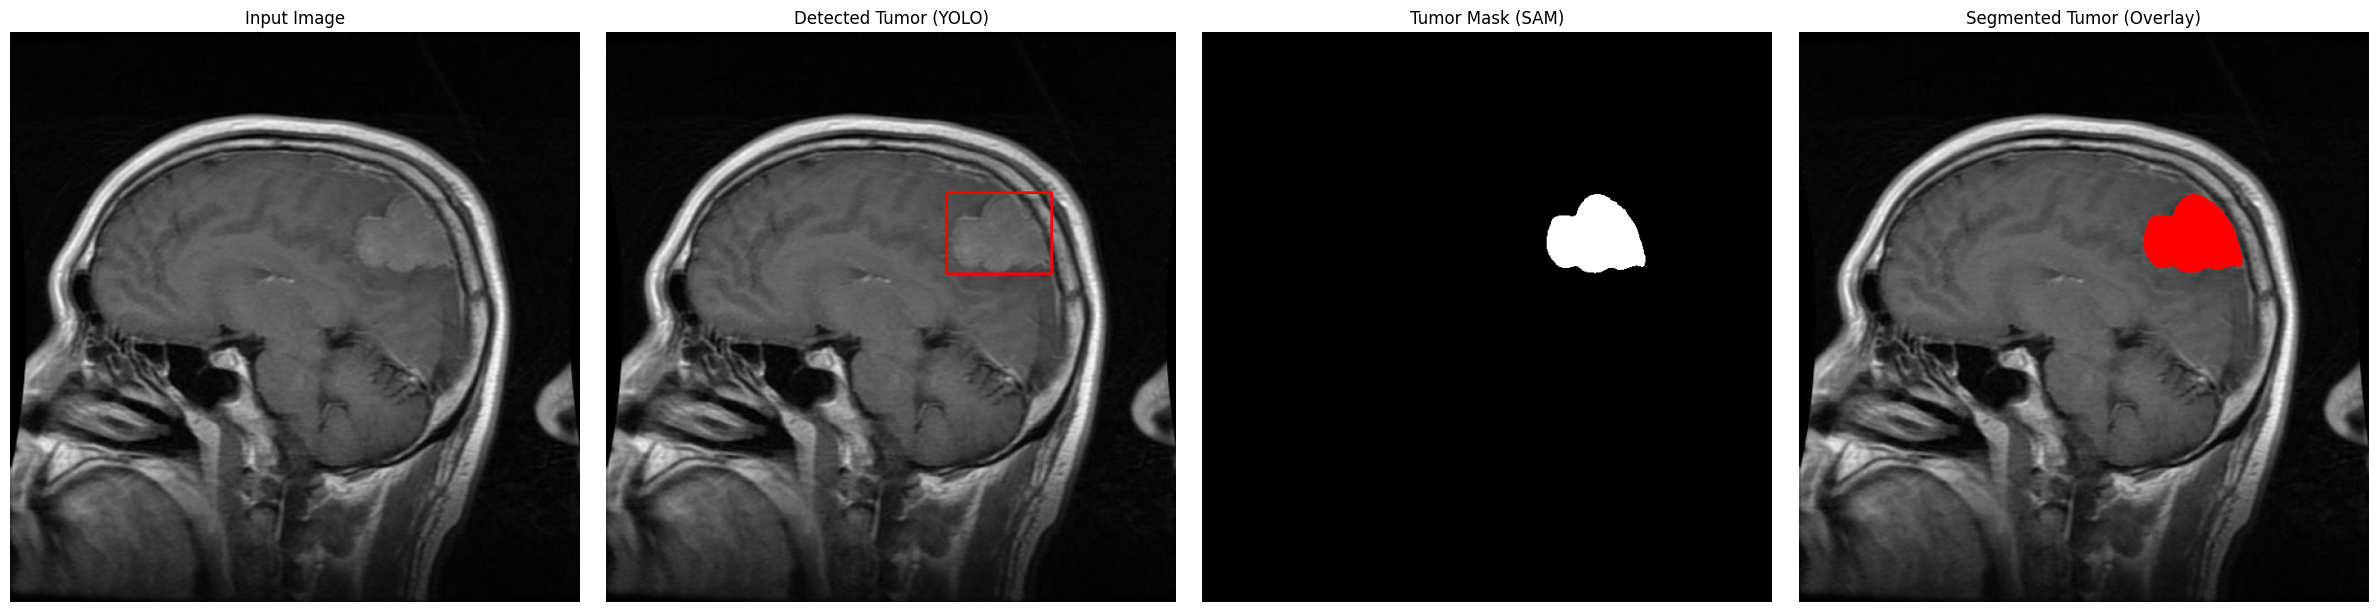

✅ Segmentation completed.


In [ ]:
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

if run_sam:
    print("Running SAM segmentation...")
    sam_checkpoint = "/content/drive/MyDrive/Colab Notebooks/sam_vit_h.pth"
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to("cpu")
    predictor = SamPredictor(sam)
    predictor.set_image(input_img)

    masks, _, _ = predictor.predict(box=np.array(bbox)[None, :], multimask_output=False)
    mask = masks[0]

    # Visualization
    x1, y1, x2, y2 = map(int, bbox)
    detected_image = input_img.copy()
    segmented_image = input_img.copy()
    cv2.rectangle(detected_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    segmented_image[mask > 0] = [255, 0, 0]

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(input_img)
    axes[0].set_title("Input Image")
    axes[1].imshow(detected_image)
    axes[1].set_title("Detected Tumor (YOLO)")
    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title("Tumor Mask (SAM)")
    axes[3].imshow(segmented_image)
    axes[3].set_title("Segmented Tumor (Overlay)")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    print("✅ Segmentation completed.")




***Brain Tumor Analysis App***

This project uses ResNet18 for tumor classification, YOLOv8 for detection, and SAM for segmentation.
It identifies tumor type (Glioma, Meningioma, Pituitary, or No Tumor) from brain MRI scans.
Results are displayed via a Gradio interface showing detection box, segmented tumor, and predicted class.


In [3]:

from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
from ultralytics import YOLO
import numpy as np
import gradio as gr
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load ResNet-18 classification model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load("/content/drive/MyDrive/tumor-1/best_resnet_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Load YOLOv8 model
yolo_model = YOLO("/content/drive/MyDrive/brain-tumor/runs/detect/train/weights/best.pt")

# Load SAM
sam_checkpoint = "/content/drive/MyDrive/Colab Notebooks/sam_vit_h.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to("cpu")
predictor = SamPredictor(sam)

# Class labels
class_names = ["Glioma Tumor", "Meningioma Tumor", "No Tumor", "Pituitary Tumor"]

# Main prediction function
def classify_detect_segment(image):
    tmp_path = "/tmp/uploaded_image.jpg"
    image.save(tmp_path)

    # Classification
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
    label = class_names[predicted_class]

    # Read input image
    input_img = cv2.imread(tmp_path)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    segmented_image = input_img.copy()

    # Detection and segmentation if tumor exists
    if label != "No Tumor":
        results = yolo_model.predict(source=input_img, conf=0.25)
        if results and results[0].boxes.xyxy.numel() > 0:
            bbox = results[0].boxes.xyxy[0].cpu().numpy().astype(int)
            x1, y1, x2, y2 = bbox

            # Draw detection box
            detected_image = input_img.copy()
            cv2.rectangle(detected_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Run SAM segmentation
            predictor.set_image(input_img)
            masks, _, _ = predictor.predict(box=bbox[None, :], multimask_output=False)
            mask = masks[0]
            segmented_image[mask > 0] = [255, 0, 0]
        else:
            detected_image = input_img
            segmented_image = input_img
    else:
        detected_image = input_img

    # Resize for Gradio UI
    return (
        cv2.resize(detected_image, (512, 512)),
        cv2.resize(segmented_image, (512, 512)),
        label
    )

# Gradio UI
gr.Interface(
    fn=classify_detect_segment,
    inputs=gr.Image(type="pil", label="Upload Brain MRI"),
    outputs=[

        gr.Image(type="numpy", label="Detection Result"),
        gr.Image(type="numpy", label="SAM Segmented Tumor"),
        gr.Textbox(label="Predicted Tumor Class")
    ],
    title="Brain Tumor Analysis & Diagnosis",
    description="Upload a brain MRI image. This app classifies the tumor, detects it using YOLOv12, and segments it using SAM.",
).launch(share=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6747881562c6a753cd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
